<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 5 - NLP - Transformer & Bert <br>
</div>
<div dir=ltr align=center>
<font color=0CBCDF size=4>
   &#x1F349; Masoud Tahmasbi  &#x1F349;  &#x1F353; Arash Ziyaei &#x1F353;
<br>
<font color=0CBCDF size=4>
   &#x1F335; Amirhossein Akbari  &#x1F335;
</div>

____

<font color=9999FF size=4>
&#x1F388; Full Name : MObina kochaknia
<br>
<font color=9999FF size=4>
&#x1F388; Student Number : 401106396

<font color=0080FF size=3>
This notebook covers two key topics. First, we implement a transformer model from scratch and apply it to a specific task. Second, we fine-tune the BERT model using LoRA for efficient adaptation to a downstream task.
</font>
<br>

**Note:**
<br>
<font color=66B2FF size=2>In this notebook, you are free to use any function or model from PyTorch to assist with the implementation. However, TensorFlow is not permitted for this exercise. This ensures consistency and alignment with the tools being focused on.</font>
<br>
<font color=red size=3>**Run All Cells Before Submission**</font>: <font color=FF99CC size=2>Before saving and submitting your notebook, please ensure you run all cells from start to finish. This practice guarantees that your notebook is self-consistent and can be evaluated correctly by others.</font>

# Section 1: Transformer

The transformer architecture consists of two main components: an encoder and a decoder. Each of these components is made up of multiple layers that include self-attention mechanisms and feedforward neural networks. The self-attention mechanism is central to the transformer, as it enables the model to assess the importance of different words in a sentence by considering their relationships with one another.


In this assignment, you should design a transformer model from scratch. You are required to implement the Encoder and Decoder components of a Transformer model.

In [1]:
!pip install datasets
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))) - skipping
Could not fetch URL https://pypi.ngc.nvidia.com/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.ngc.nvidia.com', port=443): Max retries exceeded with url: /pip/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))) - skipping
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url:

In [1]:
# Importing libraries

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math

# HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Pathlib
from pathlib import Path

# typing
from typing import Any

# Library for progress bars in loops
from tqdm import tqdm

# Importing library of warnings
import warnings

import wandb
import torchmetrics

## Part 1: Input Embeddings
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">When we observe the Transformer architecture image above, we can see that the Embeddings represent the first step of both blocks.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>InputEmbedding</code> class below is responsible for converting the input text into numerical vectors of <code>d_model</code> dimensions. To prevent that our input embeddings become extremely small, we normalize them by multiplying them by the $\sqrt{d_{model}}$.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the image below, we can see how the embeddings are created. First, we have a sentence that gets split into tokens—we will explore what tokens are later on—. Then, the token IDs—identification numbers—are transformed into the embeddings, which are high-dimensional vectors.</p>

In [2]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)


## Part 2: positional encoding
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the original paper, the authors add the positional encodings to the input embeddings at the bottom of both the encoder and decoder blocks so the model can have some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension $d_{model}$ as the embeddings, so that the two vectors can be summed and we can combine the semantic content from the word embeddings and positional information from the positional encodings.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>PositionalEncoding</code> class below, we will create a matrix of positional encodings <code>pe</code> with dimensions <code>(seq_len, d_model)</code>. We will start by filling it with $0$s.We will then apply the sine function to even indices of the positional encoding matrix while the cosine function is applied to the odd ones.</p>

<p style="
    margin-bottom: 5;
    font-size: 22px;
    font-weight: 300;
    font-family: 'Helvetica Neue', sans-serif;
    color: #000000;
  ">
    \begin{equation}
    \text{Odd Indices } (2i + 1): \quad \text{PE(pos, } 2i + 1) = \cos\left(\frac{\text{pos}}{10000^{2i / d_{model}}}\right)
    \end{equation}
</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We apply the sine and cosine functions because it allows the model to determine the position of a word based on the position of other words in the sequence, since for any fixed offset $k$, $PE_{pos + k}$ can be represented as a linear function of $PE_{pos}$. This happens due to the properties of sine and cosine functions, where a shift in the input results in a predictable change in the output.</p>

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)


## Part 3: layer normalization
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">When we look at the encoder and decoder blocks, we see several normalization layers called <b><i>Add &amp; Norm</i></b>.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>LayerNormalization</code> class below performs layer normalization on the input data. During its forward pass, we compute the mean and standard deviation of the input data. We then normalize the input data by subtracting the mean and dividing by the standard deviation plus a small number called epsilon to avoid any divisions by zero. This process results in a normalized output with a mean 0 and a standard deviation 1.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will then scale the normalized output by a learnable parameter <code>alpha</code> and add a learnable parameter called <code>bias</code>. The training process is responsible for adjusting these parameters. The final result is a layer-normalized tensor, which ensures that the scale of the inputs to layers in the network is consistent.</p>

In [4]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias


## Part 4: Feed Forward Network
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the fully connected feed-forward network, we apply two linear transformations with a ReLU activation in between. We can mathematically represent this operation as:</p>

<p style="
    margin-bottom: 5;
    font-size: 22px;
    font-weight: 300;
    font-family: 'Helvetica Neue', sans-serif;
    color: #000000;
  ">
    \begin{equation}
    \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
    \end{equation}
</p>


<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">$W_1$ and $W_2$ are the weights, while $b_1$ and $b_2$ are the biases of the two linear transformations.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>FeedForwardBlock</code> below, we will define the two linear transformations—<code>self.linear_1</code> and <code>self.linear_2</code>—and the inner-layer <code>d_ff</code>. The input data will first pass through the <code>self.linear_1</code> transformation, which increases its dimensionality from <code>d_model</code> to <code>d_ff</code>. The output of this operation passes through the ReLU activation function, which introduces non-linearity so the network can learn more complex patterns, and the <code>self.dropout</code> layer is applied to mitigate overfitting. The final operation is the <code>self.linear_2</code> transformation to the dropout-modified tensor, which transforms it back to the original <code>d_model</code> dimension.</p>

In [5]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


## Part 5: Multi Head Attention
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The Multi-Head Attention is the most crucial component of the Transformer. It is responsible for helping the model to understand complex relationships and patterns in the data.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The image below displays how the Multi-Head Attention works. It doesn't include <code>batch</code> dimension because it only illustrates the process for one single sentence.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The Multi-Head Attention block receives the input data split into queries, keys, and values organized into matrices $Q$, $K$, and $V$. Each matrix contains different facets of the input, and they have the same dimensions as the input.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We then linearly transform each matrix by their respective weight matrices $W^Q$, $W^K$, and $W^V$. These transformations will result in new matrices $Q'$, $K'$, and $V'$, which will be split into smaller matrices corresponding to different heads $h$, allowing the model to attend to information from different representation subspaces in parallel. This split creates multiple sets of queries, keys, and values for each head.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Finally, we concatenate every head into an $H$ matrix, which is then transformed by another weight matrix $W^o$ to produce the multi-head attention output, a matrix $MH-A$ that retains the input dimensionality.</p>

In [6]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x)

## Part 6: Residual Connection
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">When we look at the architecture of the Transformer, we see that each sub-layer, including the <i>self-attention</i> and <i>Feed Forward</i> blocks, adds its output to its input before passing it to the <i>Add &amp; Norm</i> layer. This approach integrates the output with the original input in the <i>Add &amp; Norm</i> layer. This process is known as the skip connection, which allows the Transformer to train deep networks more effectively by providing a shortcut for the gradient to flow through during backpropagation.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>ResidualConnection</code> class below is responsible for this process.</p>

In [7]:
class ResidualConnection(nn.Module):

        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)

        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))


## Part 7: Encoder
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will now build the encoder. We create the <code>EncoderBlock</code> class, consisting of the Multi-Head Attention and Feed Forward layers, plus the residual connections.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the original paper, the Encoder Block repeats six times. We create the <code>Encoder</code> class as an assembly of multiple <code>EncoderBlock</code>s. We also add layer normalization as a final step after processing the input through all its blocks.</p>

In [8]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [9]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## Part 8: Decoder
<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Similarly, the Decoder also consists of several DecoderBlocks that repeat six times in the original paper. The main difference is that it has an additional sub-layer that performs multi-head attention with a <i>cross-attention</i> component that uses the output of the Encoder as its keys and values while using the Decoder's input as queries.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">For the Output Embedding, we can use the same <code>InputEmbeddings</code> class we use for the Encoder. You can also notice that the self-attention sub-layer is <i>masked</i>, which restricts the model from accessing future elements in the sequence.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will start by building the <code>DecoderBlock</code> class, and then we will build the <code>Decoder</code> class, which will assemble multiple <code>DecoderBlock</code>s.</p>

In [10]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [11]:
class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">You can see in the Decoder image that after running a stack of <code>DecoderBlock</code>s, we have a Linear Layer and a Softmax function to the output of probabilities. The <code>ProjectionLayer</code> class below is responsible for converting the output of the model into a probability distribution over the <i>vocabulary</i>, where we select each output token from a vocabulary of possible tokens.</p>

In [12]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        return self.proj(x)

## Part 9: Building the Transformer

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We finally have every component of the Transformer architecture ready. We may now construct the Transformer by putting it all together.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>Transformer</code> class below, we will bring together all the components of the model's architecture.</p>

In [13]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        return self.projection_layer(x)

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The architecture is finally ready. We now define a function called <code>build_transformer</code>, in which we define the parameters and everything we need to have a fully operational Transformer model for the task of <b>machine translation</b>.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will set the same parameters as in the original paper, <a href = "https://arxiv.org/pdf/1706.03762.pdf"><i>Attention Is All You Need</i></a>, where $d_{model}$ = 512, $N$ = 6, $h$ = 8, dropout rate $P_{drop}$ = 0.1, and $d_{ff}$ = 2048.</p>

In [14]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

The model is now ready to be trained!

## Part 10: Tokenizer

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Tokenization is a crucial preprocessing step for our Transformer model. In this step, we convert raw text into a number format that the model can process.  </p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">There are several Tokenization strategies. We will use the <i>word-level tokenization</i> to transform each word in a sentence into a token.</p>

<center>
    <img src = "https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F8d5e749c-b0bd-4496-85a1-9b4397ad935f_1400x787.jpeg" width = 800, height= 800>
<p style = "font-size: 16px;
            font-family: 'Georgia', serif;
            text-align: center;
            margin-top: 10px;">Different tokenization strategies. Source: <a href = "https://shaankhosla.substack.com/p/talking-tokenization">shaankhosla.substack.com</a>.</p>
</center>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">After tokenizing a sentence, we map each token to an unique integer ID based on the created vocabulary present in the training corpus during the training of the tokenizer. Each integer number represents a specific word in the vocabulary.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Besides the words in the training corpus, Transformers use special tokens for specific purposes. These are some that we will define right away:</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px"><b>• [UNK]:</b> This token is used to identify an unknown word in the sequence.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px"><b>• [PAD]:</b> Padding token to ensure that all sequences in a batch have the same length, so we pad shorter sentences with this token. We use attention masks to <i>"tell"</i> the model to ignore the padded tokens during training since they don't have any real meaning to the task.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px"><b>•  [SOS]:</b> This is a token used to signal the <i>Start of Sentence</i>.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px"><b>•  [EOS]:</b> This is a token used to signal the <i>End of Sentence</i>.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>build_tokenizer</code> function below, we ensure a tokenizer is ready to train the model. It checks if there is an existing tokenizer, and if that is not the case, it trains a new tokenizer.</p>

In [15]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace


def get_or_build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    if not Path.exists(tokenizer_path):
        # Most of the is code taken from: https://huggingface.co/docs/tokenizers/quicktour
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

## Part 11: Load Dataset

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">For this task, we will use the <a href = "opus_books · Datasets at Hugging Face">OpusBooks dataset</a>, available on 🤗Hugging Face. This dataset consists of two features, <code>id</code> and <code>translation</code>. The <code>translation</code> feature contains pairs of sentences in different languages, such as Spanish and Portuguese, English and French, and so forth.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">I first tried translating sentences from English to Portuguese—my native tongue — but there are only 1.4k examples for this pair, so the results were not satisfying in the current configurations for this model. I then tried to use the English-French pair due to its higher number of examples—127k—but it would take too long to train with the current configurations. I then opted to train the model on the English-Italian pair, the same one used in the <a href = "https://youtu.be/ISNdQcPhsts?si=253J39cose6IdsLv">Coding a Transformer from scratch on PyTorch, with full explanation, training and inference
</a> video, as that was a good balance between performance and time of training.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We start by defining the <code>get_all_sentences</code> function to iterate over the dataset and extract the sentences according to the language pair defined—we will do that later.</p>

In [16]:
def get_all_sentences(ds, lang):
    for item in ds:
        yield item['translation'][lang]


<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>get_ds</code> function is defined to load and prepare the dataset for training and validation. In this function, we build or load the tokenizer, split the dataset, and create DataLoaders, so the model can successfully iterate over the dataset in batches. The result of these functions is tokenizers for the source and target languages plus the DataLoader objects.</p>

In [17]:
def get_ds(config):
    ds_raw = load_dataset('opus_books', f"{config['lang_src']}-{config['lang_tgt']}", split='train')

    tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])

    train_ds_size = int(0.9 * len(ds_raw))
    val_ds_size = (len(ds_raw) - train_ds_size)
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    max_len_src = 0
    max_len_tgt = 0

    for item in ds_raw:
        src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')


    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt


<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We define the <code>casual_mask</code> function to create a mask for the attention mechanism of the decoder. This mask prevents the model from having information about future elements in the sequence. </p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We start by making a square grid filled with ones. We determine the grid size with the <code>size</code> parameter. Then, we change all the numbers above the main diagonal line to zeros. Every number on one side becomes a zero, while the rest remain ones. The function then flips all these values, turning ones into zeros and zeros into ones. This process is crucial for models that predict future tokens in a sequence.</p>

In [18]:
def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0


<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>BilingualDataset</code> class processes the texts of the target and source languages in the dataset by tokenizing them and adding all the necessary special tokens. This class also certifies that the sentences are within a maximum sequence length for both languages and pads all necessary sentences.</p>

In [19]:
class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # We will add <s> and </s>
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # (seq_len)
            "decoder_input": decoder_input,  # (seq_len)
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1, 1, seq_len)
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len),
            "label": label,  # (seq_len)
            "src_text": src_text,
            "tgt_text": tgt_text,
        }



## Part 12: Validation Loop

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will now create two functions for the validation loop. The validation loop is crucial to evaluate model performance in translating sentences from data it has not seen during training.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We will define two functions. The first function, <code>greedy_decode</code>, gives us the model's output by obtaining the most probable next token. The second function, <code>run_validation</code>, is responsible for running the validation process in which we decode the model's output and compare it with the reference text for the target sentence.</p>

In [20]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    encoder_output = model.encode(source, source_mask)
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break

        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)



In [21]:
import os
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_step, num_examples=2):
    model.eval()
    count = 0

    source_texts = []
    expected = []
    predicted = []

    try:
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            print_msg('-'*console_width)
            print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break

## Part 13: Training Loop

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We are ready to train our Transformer model on the OpusBook dataset for the English to Italian translation task.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We first start by defining the <code>get_model</code> function to load the model by calling the <code>build_transformer</code> function we have previously defined. This function uses the <code>config</code> dictionary to set a few parameters.</p>

In [22]:
def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], config['seq_len'], d_model=config['d_model'])
    return model


<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">I have mentioned the <code>config</code> dictionary several times throughout this notebook. Now, it is time to create it.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the following cell, we will define two functions to configure our model and the training process.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In the <code>get_config</code> function, we define crucial parameters for the training process. <code>batch_size</code> for the number of training examples used in one iteration, <code>num_epochs</code> as the number of times the entire dataset is passed forward and backward through the Transformer, <code>lr</code> as the learning rate for the optimizer, etc. We will also finally define the pairs from the OpusBook dataset, <code>'lang_src': 'en'</code> for selecting English as the source language and <code>'lang_tgt': 'it'</code> for selecting Italian as the target language.</p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">The <code>get_weights_file_path</code> function constructs the file path for saving or loading model weights for any specific epoch.</p>

In [23]:
from pathlib import Path

def get_config():
    return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,
        "datasource": 'opus_books',
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "/content/drive/MyDrive/weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
    }
def get_weights_file_path(config, epoch: str):
    model_folder = f"{config['model_folder']}"
    model_filename = f"{config['model_basename']}{epoch}.pt"
    return str(Path('.') / model_folder / model_filename)

def latest_weights_file_path(config):
    model_folder = f"{config['model_folder']}"
    model_filename = f"{config['model_basename']}*"
    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None
    weights_files.sort()
    return str(weights_files[-1])

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">We finally define our last function, <code>train_model</code>, which takes the <code>config</code> arguments as input. </p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">In this function, we will set everything up for the training. We will load the model and its necessary components onto the GPU for faster training, set the <code>Adam</code> optimizer, and configure the <code>CrossEntropyLoss</code> function to compute the differences between the translations output by the model and the reference translations from the dataset. </p>

<p style = "font-family: 'Helvetica Neue', Arial, sans-serif; text-align: left; font-size: 17.5px">Every loop necessary for iterating over the training batches, performing backpropagation, and computing the gradients is in this function. We will also use it to run the validation function and save the current state of the model.</p>

In [24]:
def train_model(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    initial_epoch = 0
    global_step = 0
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
        del state

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)


    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:

            encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            label = batch['label'].to(device) # (B, seq_len)

            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})


            loss.backward()

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step)


We can now train the model!

In [47]:
torch.cuda.empty_cache()

In [25]:
from torch.optim import Adam

if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    config['num_epochs'] = 5
    config['preload'] = None
    train_model(config)

Using device: cuda
Max length of source sentence: 309
Max length of target sentence: 274


Processing Epoch 00: 100%|██████████| 3638/3638 [18:03<00:00,  3.36it/s, loss=5.691]


--------------------------------------------------------------------------------
    SOURCE: 'Shall we have another turn?
    TARGET: — Ebbene, ancora un giro?
 PREDICTED: — E non è ?
--------------------------------------------------------------------------------
    SOURCE: Five minutes later the brothers met again in the dining-room.
    TARGET: Dopo cinque minuti i due fratelli si ritrovavano in sala da pranzo.
 PREDICTED: Il suo momento , e il suo momento , e il suo viso .
--------------------------------------------------------------------------------


Processing Epoch 01: 100%|██████████| 3638/3638 [18:15<00:00,  3.32it/s, loss=6.170]


--------------------------------------------------------------------------------
    SOURCE: Oblonsky laughed.
    TARGET: Stepan Arkad’ic rise.
 PREDICTED: Dolly si mise a Kitty .
--------------------------------------------------------------------------------
    SOURCE: Hoping to find her alone, Vronsky, as usual, to attract less attention, alighted before crossing the little bridge that led to the house and walked on.
    TARGET: Con la speranza di trovarla sola, Vronskij, come del resto faceva sempre per non essere notato, smontò prima di arrivare al ponte, e andò a piedi.
 PREDICTED: La principessa , la sua moglie , Levin , si era stato in cui , si era stato in piedi , e , si mise a .
--------------------------------------------------------------------------------


Processing Epoch 02: 100%|██████████| 3638/3638 [18:20<00:00,  3.30it/s, loss=5.335]


--------------------------------------------------------------------------------
    SOURCE: I believe this is the longest uninterrupted stretch anywhere above Teddington, and the Oxford Club make use of it for their trial eights.
    TARGET: Credo che sia il più lungo tratto ininterrotto dopo Teddington, e l’Oxford Club lo usa per le sue gare.
 PREDICTED: Io sono stato stato di più di più di più di più di più di , e a .
--------------------------------------------------------------------------------
    SOURCE: The cattle-yard, the fruit and vegetable gardens, the meadows and the corn-fields, divided into several parts, should come under different sections.
    TARGET: La stalla, il giardino, l’orto, i prati, i campi, tutti divisi in settori, dovevano costituire parti separate.
 PREDICTED: Il vecchio , il vento , e il suo , e il vento di , il vento di , la nostra .
--------------------------------------------------------------------------------


Processing Epoch 03: 100%|██████████| 3638/3638 [18:13<00:00,  3.33it/s, loss=5.441]


--------------------------------------------------------------------------------
    SOURCE: 'You should have your hair cut; it will be too heavy, especially on the top.'
    TARGET: — Dovresti tagliarti i capelli, se no ti pesano, specie sulla zucca.
 PREDICTED: — Tu ti , e voi sono in mano , ma non è possibile .
--------------------------------------------------------------------------------
    SOURCE: Levin turned away from him quickly and went far down one of the avenues, where he continued walking up and down alone.
    TARGET: Levin si voltò in fretta e andò via in fondo al viale, continuando a camminare solo, avanti e indietro.
 PREDICTED: Levin si alzò e si mise a , e , dopo aver fatto un po ’ di nuovo , si mise a guardare .
--------------------------------------------------------------------------------


Processing Epoch 04: 100%|██████████| 3638/3638 [18:12<00:00,  3.33it/s, loss=4.113]


--------------------------------------------------------------------------------
    SOURCE: "No; he said he had known you long, and that he could take the liberty of installing himself here till you returned." "The devil he did!
    TARGET: È partito? — No, dice di conoscervi da lunga data e che può permettersi di rimanere alla villa fino al vostro ritorno.
 PREDICTED: — No , — disse , — ma voi avete fatto tanto tempo che vi per la forza di .
--------------------------------------------------------------------------------
    SOURCE: Alexis has not been here six months, and I think he is already a member of five or six different institutions: Guardian of the Poor, Justice of the Peace, a Member of a Council, a juryman, and Member of some Commission on Horses...
    TARGET: Aleksej è qui da sei mesi, ed è già membro di cinque o sei, mi pare, istituzioni diverse: è curatore, giudice, consigliere distrettuale, giurato, qualcosa di ippico.
 PREDICTED: Aleksej Aleksandrovic non ha altro ch

# Section 2: BERT and LoRA

Welcome to Section 2 of our Machine Learning assignment! I hope you've been enjoying the journey so far! 😊

 In this section, you will gain hands-on experience with [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) and [LoRA](https://arxiv.org/abs/2106.09685) (Low-Rank Adaptation) for text classification tasks. The section is divided into three main parts, each focusing on different aspects of NLP techniques.

## Assignment Structure

### Part 1: Data Preparation and Preprocessing
In this part, you will work with a text classification dataset. You will learn how to:
- Download and load the dataset
- Perform necessary preprocessing steps
- Implement data cleaning and transformation techniques
- Prepare the data in a format suitable for BERT training

### Part 2: Building a Small BERT Model
You will create and train a small BERT model from scratch using the Hugging Face [Transformers](https://huggingface.co/docs/transformers/en/index) library. This part will help you understand:
- The architecture of BERT
- How to configure and initialize a BERT model
- Training process and optimization
- Model evaluation and performance analysis

### Part 3: Fine-tuning with LoRA
In the final part, you will work with a pre-trained [TinyBERT](https://arxiv.org/abs/1909.10351) model and use LoRA for efficient fine-tuning. You will:
- Load a pre-trained TinyBERT model
- Implement LoRA adaptation and fine-tune the model on our classification task
- Compare the results with the previous approach

---

> **NOTE**:  
> Throughout this notebook, make an effort to include sufficient visualizations to enhance understanding:  
> - In the data processing section, display the results of your operations (e.g., show data samples or distributions after preprocessing).  
> - In the classification section, report various evaluation metrics such as accuracy, precision, recall, and F1-score to thoroughly assess your model's performance.  
> - Additionally, take a moment to compare the sizes of the models discussed in this notebook with today’s enormous models. This will help you appreciate the challenges and computational demands associated with training such massive models. 😵‍💫

---


## Part 1: Data Preparation and Preprocessing
We'll be working with the [Consumer Complaint](https://catalog.data.gov/dataset/consumer-complaint-database) dataset, which contains ***complaints*** submitted by consumers about financial products and services. Our goal is to build a classifier that can automatically identify the type of complaint based on the consumer's text description. For this task, we will work with a smaller subset of the dataset, available for download through this [link](https://drive.google.com/file/d/1SpIHksR-WzruEgUjp1SQKGG8bZPnJJoN/view?usp=sharing).

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

### 1.2 Loading the Data

In [ ]:
file_path = 'complaints_small.csv'
data = pd.read_csv(file_path)
data = data.rename(columns={'Consumer complaint narrative':'Complaint'})
data

,Product,Complaint
0,"Credit reporting, credit repair services, or o...",My credit reports are inaccurate. These inaccu...
1,Student loan,Beginning in XX/XX/XXXX I had taken out studen...
2,Credit reporting or other personal consumer re...,I am disputing a charge-off on my account that...
3,"Credit reporting, credit repair services, or o...","I did not consent to, authorize, nor benefit f..."
4,Credit reporting or other personal consumer re...,I am a federally protected consumer and I am a...
...,...,...
941123,Mortgage,US Bank 's online mortgage payment is system i...
941124,Debt collection,There is abundant evidence of the use of abusi...
941125,Credit reporting,"I recently wrote and sent out dispute letter, ..."
941126,Credit card or prepaid card,Capital One has made false statements regardin...


### 1.3 Data Sampling and Class Distribution Analysis

Working with large datasets can be computationally intensive during development. Additionally, imbalanced class distribution can affect model performance. In this section, you'll sample the data and analyze class distributions to make informed decisions about your training dataset.

---

We'll work with a manageable portion of the data to develop and test our approach. While using the complete dataset would likely yield better results, a smaller sample allows us to prototype our solution more efficiently.


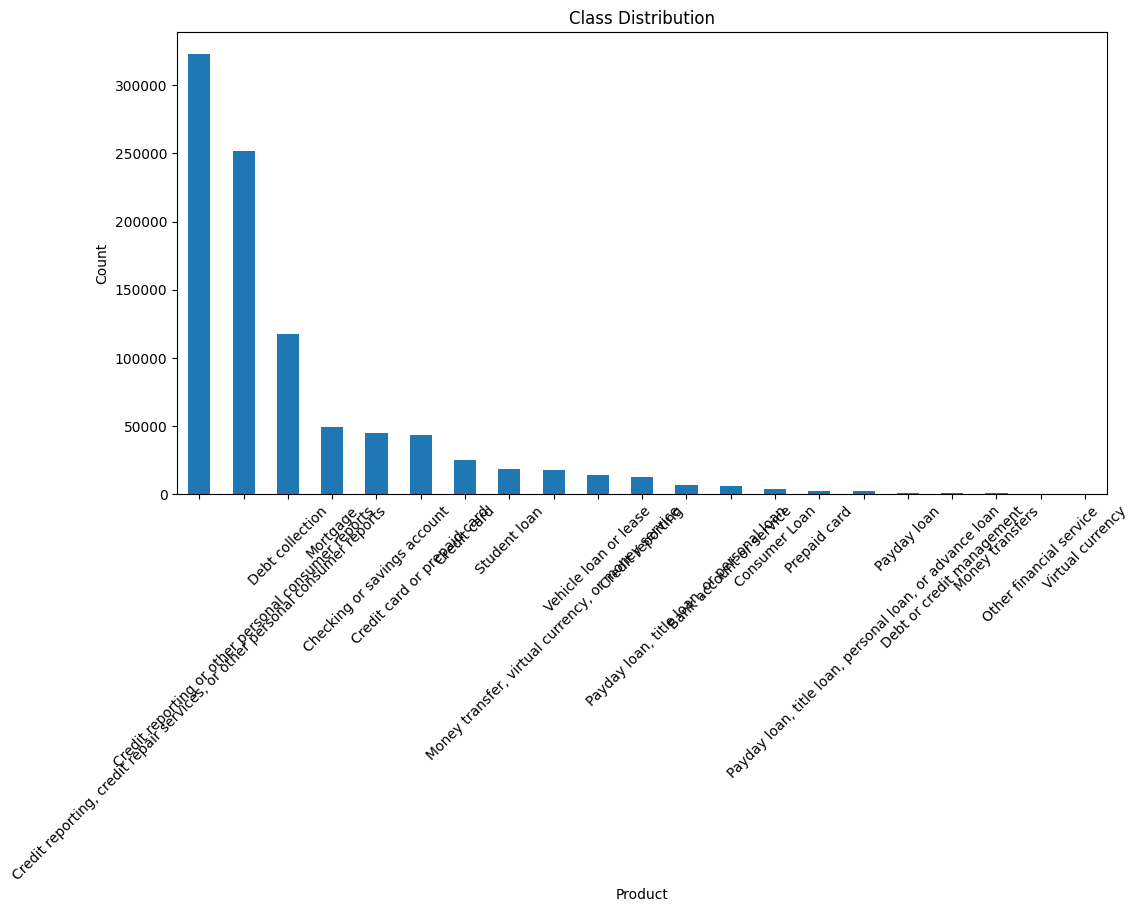

Sampled dataset shape: (500, 2)


,Product,Complaint
335123,Credit reporting or other personal consumer re...,"Upon reviewing my credit report, I have identi..."
601718,Mortgage,I was doing a rate check to refinance. The age...
847752,"Credit reporting, credit repair services, or o...",This is my 2nd request that I have been a vict...
765316,Credit reporting or other personal consumer re...,I'm sending this compliant to inform credit bu...
798300,"Credit reporting, credit repair services, or o...",Im submitting a complaint to you today to info...


In [ ]:
import matplotlib.pyplot as plt

data = data.dropna()

data['Product'] = data['Product'].str.strip()
data['Complaint'] = data['Complaint'].str.strip()

class_distribution = data['Product'].value_counts()

plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print("=="*50)

sample_size = 500
sampled_data = data.sample(n=sample_size, random_state=42)

print(f"Sampled dataset shape: {sampled_data.shape}")
sampled_data.head()


---

Let's examine the distribution of ***complaints*** types in our dataset. You'll notice that some products have significantly more instances than others, and some categories are quite similar. For example:

- Multiple categories might refer to similar financial products
- Some categories might have very few examples
- Certain categories might be subcategories of others

You have two main approaches to handle this situation:

1. **Merging Similar Classes:** Identify categories that represent similar products/services and Combine them to create more robust, general categories

2. **Selecting Major Classes:** Only select the categories with sufficient representation



> You may choose any approach, but after this step, your data must include **at least five** distinct classes.



In [ ]:
print(f"Class Distribution: {class_distribution}")

print("=="*50)

merge_mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": "Credit Reporting",
    "Credit reporting or other personal consumer reports": "Credit Reporting",
    "Credit reporting": "Credit Reporting",
    "Payday loan, title loan, or personal loan": "Payday Loans",
    "Payday loan, title loan, personal loan, or advance loan": "Payday Loans",
    "Payday loan": "Payday Loans",
}

data['Product'] = data['Product'].replace(merge_mapping)

updated_class_distribution = data['Product'].value_counts()
print(f"Updated Class Distribution: {updated_class_distribution}")

print("=="*50)

min_count = 20000
major_classes = class_distribution[class_distribution >= min_count].index
filtered_data = data[data['Product'].isin(major_classes)]

print(f"Filtered dataset shape: {filtered_data.shape}")
print(filtered_data['Product'].value_counts())


Class Distribution: Product
Credit reporting, credit repair services, or other personal consumer reports    322966
Credit reporting or other personal consumer reports                             252019
Debt collection                                                                 117285
Mortgage                                                                         49358
Checking or savings account                                                      44580
Credit card or prepaid card                                                      43575
Credit card                                                                      24776
Student loan                                                                     18742
Money transfer, virtual currency, or money service                               17962
Vehicle loan or lease                                                            13777
Credit reporting                                                                 12641
Payday loan, ti

---
### 1.4 Data Encoding and Text Preprocessing

Before training our model, we need to prepare both our target labels and text data. This involves converting categorical labels into numerical format and cleaning our text data to improve model performance.

In [ ]:
import re

label_encoder = LabelEncoder()
filtered_data['Label'] = label_encoder.fit_transform(filtered_data['Product'])

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)
print("=="*50)

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

filtered_data['Complaint'] = filtered_data['Complaint'].apply(preprocess_text)
filtered_data = filtered_data[filtered_data['Complaint'].str.split().apply(len) >= 10]
print(filtered_data.head())
print("=="*50)

Label Mapping: {'Checking or savings account': 0, 'Credit card': 1, 'Credit card or prepaid card': 2, 'Debt collection': 3, 'Mortgage': 4}


C:\Users\miirzamiir\AppData\Local\Temp\ipykernel_18900\353166463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Label'] = label_encoder.fit_transform(filtered_data['Product'])
C:\Users\miirzamiir\AppData\Local\Temp\ipykernel_18900\353166463.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Complaint'] = filtered_data['Complaint'].apply(preprocess_text)


                        Product  \
5               Debt collection   
12              Debt collection   
14              Debt collection   
25              Debt collection   
27  Credit card or prepaid card   

                                            Complaint  Label  
5   RE  XXXX partial account  XXXX XXXX XXXX XXXX ...      3  
12  I was shocked when I reviewed my credit report...      3  
14  On or about XXXX XXXX XXXX the XXXX XXXX XXXX ...      3  
25  Upon reviewing my credit report I have identif...      3  
27  I had transactions that were made on my cardco...      2  


## 1.5 Dataset Creation and Tokenization

For training our BERT model, we need to:
1. Create a custom Dataset class that will handle tokenization
2. Split the data into training and testing sets
3. Use BERT's tokenizer to convert text into a format suitable for the model

In [ ]:
class ComplaintDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    filtered_data['Complaint'], filtered_data['Label'], test_size=0.2, random_state=42
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = ComplaintDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = ComplaintDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

## Part 2: Training a Small-Size BERT Model

In this part, we will explore how to build and train a small-sized BERT model for our classification task. Instead of using the full-sized BERT model, which is computationally expensive, we will create a smaller version using the Transformers library.

In [ ]:
num_labels = len(filtered_data['Product'].unique())
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Trainable Parameters: 109486085


---

Now that you have defined your model, it's time to train it!☠️

Training a model of this size can take some time, depending on the available resources. To manage this, you can train your model for just **2–3 epochs** to demonstrate progress. Here are some hints:
- **Training Metrics:** Ensure you print enough metrics, such as loss and accuracy, to track the training progress.
- **Interactive Monitoring:** Use the `tqdm` library to display the progress of your training loop in real-time.

In [ ]:
from sklearn.metrics import classification_report


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch Loss: {total_loss:.4f}, Accuracy: {correct / total:.4f}")

# TODO : Evaluate the model on test dataset
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

c:\Users\miirzamiir\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


100%|██████████| 1738/1738 [1:27:01<00:00,  3.00s/it]


Epoch Loss: 782.5101, Accuracy: 0.8301
Epoch 2/3


100%|██████████| 1738/1738 [1:27:08<00:00,  3.01s/it]


Epoch Loss: 577.8015, Accuracy: 0.8720
Epoch 3/3


100%|██████████| 1738/1738 [1:27:56<00:00,  3.04s/it]


Epoch Loss: 473.4544, Accuracy: 0.8930
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8887
           1       0.71      0.37      0.49      4894
           2       0.65      0.80      0.72      8692
           3       0.94      0.94      0.94     23272
           4       0.94      0.96      0.95      9850

    accuracy                           0.86     55595
   macro avg       0.82      0.79      0.80     55595
weighted avg       0.86      0.86      0.86     55595



## Part 3: Fine-Tuning TinyBERT with LoRA

As you have experienced, training even a small-sized BERT model can be computationally intensive and time-consuming. To address these challenges, we explore **Parameter-Efficient Fine-Tuning (PEFT)** methods, which allow us to utilize the power of large pretrained models without requiring extensive resources.

---

### **Parameter-Efficient Fine-Tuning (PEFT)**

PEFT methods focus on fine-tuning only a small portion of the model’s parameters while keeping most of the pretrained weights frozen. This drastically reduces the computational and storage requirements while leveraging the rich knowledge embedded in pretrained models.

One popular PEFT method is LoRA (Low-Rank Adaptation).

- **What is LoRA?**

LoRA introduces a mechanism to fine-tune large language models by injecting small low-rank matrices into the model's architecture. Instead of updating all parameters during training, LoRA trains these small matrices while keeping the majority of the original parameters frozen.  This is achieved as follows:

1. **Frozen Weights**: The pretrained weights of the model, represented as a weight matrix $ W \in \mathbb{R}^{d \times k} $, remain **frozen** during fine-tuning.

2. **Low-Rank Decomposition**:
   Instead of directly updating $ W $, LoRA introduces two trainable matrices, $ A \in \mathbb{R}^{d \times r} $ and $ B \in \mathbb{R}^{r \times k} $, where $ r \ll \min(d, k) $.  
   These matrices approximate the update to $ W $ as:
   $$
   \Delta W = A \cdot B
   $$

   Here, $ r $, the rank of the decomposition, is a key hyperparameter that determines the trade-off between computational cost and model capacity.

3. **Adaptation**:
   During training, instead of updating $ W $, the adapted weight is:
   $$
   W' = W + \Delta W = W + A \cdot B
   $$
   Only the low-rank matrices $ A $ and $ B $ are optimized, while $ W $ remains fixed.

4. **Efficiency**:
   Since $ r $ is much smaller than $ d $ and $ k $, the number of trainable parameters in $ A $ and $ B $ is significantly less than in $ W $. This makes the approach highly efficient both in terms of computation and memory.

---

###  **Fine-Tuning TinyBERT**

For this part, we will fine-tune **TinyBERT**, a distilled version of BERT, using the LoRA method.

- **What is TinyBERT?**

TinyBERT is a lightweight version of the original BERT model created through knowledge distillation. It significantly reduces the model size and inference latency while preserving much of the original BERT’s effectiveness. Here are some key characteristics of TinyBERT:
- It is designed to be more resource-efficient for tasks such as classification, question answering, and more.
- TinyBERT retains a compact structure with fewer layers and parameters, making it ideal for fine-tuning with limited computational resources.


> Similar to the previous section, training this model might take some time. Given the resource limitations, you can train the model for just **2-3 epochs** to demonstrate the process.


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
######################  TODO  ########################
######################  TODO  ########################

# Load the pre-trained TinyBERT
model_name = "prajjwal1/bert-tiny"
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define LoRA Configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

######################  TODO  ########################
######################  TODO  ########################

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
######################  TODO  ########################
######################  TODO  ########################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Apply LoRA to model
lora_model = get_peft_model(base_model, lora_config)
lora_model.to(device)

# TODO: Show the number of trainable parameters
trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

# Training configuration
learning_rate = 5e-5
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

######################  TODO  ########################
######################  TODO  ########################

Trainable parameters: 8837


In [ ]:
######################  TODO  ########################
######################  TODO  ########################

num_epochs = 3

# Training loop
for epoch in range(num_epochs):

    lora_model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = lora_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


# TODO : Evaluate the model on test dataset

lora_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = lora_model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

100%|██████████| 1738/1738 [11:27<00:00,  2.53it/s]


Epoch 1/3, Loss: 1.2411


100%|██████████| 1738/1738 [11:11<00:00,  2.59it/s]


Epoch 2/3, Loss: 0.8479


100%|██████████| 1738/1738 [11:06<00:00,  2.61it/s]


Epoch 3/3, Loss: 0.7810


100%|██████████| 435/435 [02:48<00:00,  2.59it/s]

Test Accuracy: 0.7366
